# Escolher algum ambiente

Foi escolhido como ambiente de estudo o '**Intersection**', disponível em: http://highway-env.farama.org/environments/intersection/

In [1]:
import aux_functions

STACK_SIZE = 4

env = aux_functions.intersection_v1(STACK_SIZE = STACK_SIZE)

/home/avlis/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
env.reset()

for _ in range(15):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done or truncated:
        obs, info = env.reset()
env.close()

## Observações no formato de imagem

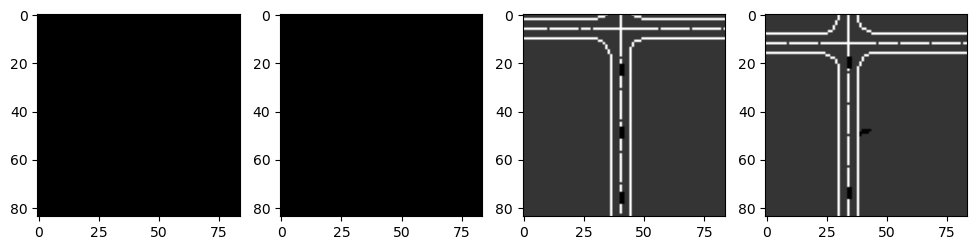

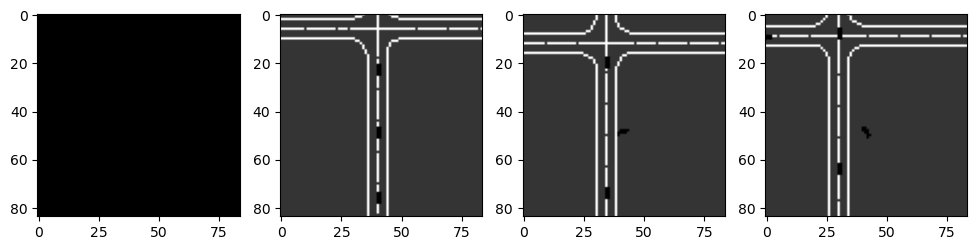

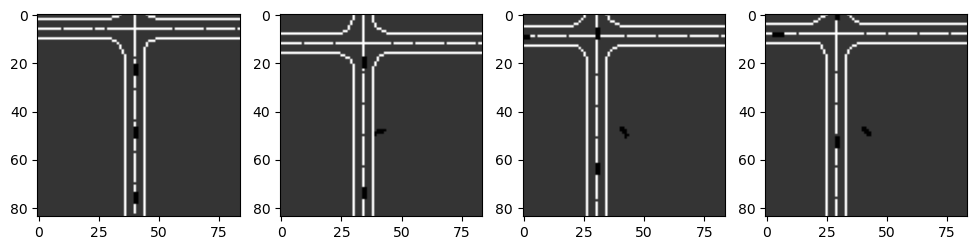

In [3]:
from matplotlib import pyplot as plt

env.reset()

for _ in range(3):
    obs, reward, done, truncated, info = env.step(env.action_space.sample())

    fig, axes = plt.subplots(ncols = STACK_SIZE, figsize=(12, 5))

    if STACK_SIZE > 1:
        for i, ax in enumerate(axes.flat):
            ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    else:
        axes.imshow(obs[0, ...].T, cmap=plt.get_cmap('gray'))

plt.show()

# Escolher algoritmos

In [4]:
TOTAL_TIMESTEPS = 5_000
LOG_INTERVAL = 500
BUFFER_SIZE = 100_000

## DDPG (baseline)

In [110]:
from stable_baselines3 import DDPG

env.reset()

model = DDPG("CnnPolicy", env, verbose=1, buffer_size=BUFFER_SIZE)
model.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=LOG_INTERVAL, progress_bar=True)
model.save("ddpg_intersection")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.27GB
  warnings.warn(


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.08     |
|    ep_rew_mean     | 0.42     |
| time/              |          |
|    episodes        | 50       |
|    fps             | 2        |
|    time_elapsed    | 55       |
|    total_timesteps | 154      |
| train/             |          |
|    actor_loss      | -0.418   |
|    critic_loss     | 0.159    |
|    learning_rate   | 0.001    |
|    n_updates       | 54       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.06     |
|    ep_rew_mean     | 0.63     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 2        |
|    time_elapsed    | 86       |
|    total_timesteps | 206      |
| train/             |          |
|    actor_loss      | -0.263   |
|    critic_loss     | 0.426    |
|    learning_rate   | 0.001    |
|    n_updates       | 106      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08     |
|    ep_rew_mean     | 0.9      |
| time/              |          |
|    episodes        | 150      |
|    fps             | 2        |
|    time_elapsed    | 119      |
|    total_timesteps | 262      |
| train/             |          |
|    actor_loss      | -0.662   |
|    critic_loss     | 0.0708   |
|    learning_rate   | 0.001    |
|    n_updates       | 162      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.07     |
|    ep_rew_mean     | 0.97     |
| time/              |          |
|    episodes        | 200      |
|    fps             | 2        |
|    time_elapsed    | 150      |
|    total_timesteps | 313      |
| train/             |          |
|    actor_loss      | -0.594   |
|    critic_loss     | 0.312    |
|    learning_rate   | 0.001    |
|    n_updates       | 213      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.01     |
|    ep_rew_mean     | 0.93     |
| time/              |          |
|    episodes        | 250      |
|    fps             | 1        |
|    time_elapsed    | 181      |
|    total_timesteps | 363      |
| train/             |          |
|    actor_loss      | -0.536   |
|    critic_loss     | 0.37     |
|    learning_rate   | 0.001    |
|    n_updates       | 263      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.02     |
|    ep_rew_mean     | 0.92     |
| time/              |          |
|    episodes        | 300      |
|    fps             | 1        |
|    time_elapsed    | 213      |
|    total_timesteps | 415      |
| train/             |          |
|    actor_loss      | -0.715   |
|    critic_loss     | 0.668    |
|    learning_rate   | 0.001    |
|    n_updates       | 315      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.03     |
|    ep_rew_mean     | 0.97     |
| time/              |          |
|    episodes        | 350      |
|    fps             | 1        |
|    time_elapsed    | 244      |
|    total_timesteps | 466      |
| train/             |          |
|    actor_loss      | -0.709   |
|    critic_loss     | 0.293    |
|    learning_rate   | 0.001    |
|    n_updates       | 366      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.89     |
| time/              |          |
|    episodes        | 400      |
|    fps             | 1        |
|    time_elapsed    | 279      |
|    total_timesteps | 524      |
| train/             |          |
|    actor_loss      | -0.77    |
|    critic_loss     | 0.0433   |
|    learning_rate   | 0.001    |
|    n_updates       | 424      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.14     |
|    ep_rew_mean     | 0.88     |
| time/              |          |
|    episodes        | 450      |
|    fps             | 1        |
|    time_elapsed    | 313      |
|    total_timesteps | 580      |
| train/             |          |
|    actor_loss      | -0.706   |
|    critic_loss     | 0.147    |
|    learning_rate   | 0.001    |
|    n_updates       | 480      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.24     |
|    ep_rew_mean     | 0.92     |
| time/              |          |
|    episodes        | 500      |
|    fps             | 1        |
|    time_elapsed    | 352      |
|    total_timesteps | 648      |
| train/             |          |
|    actor_loss      | -0.722   |
|    critic_loss     | 0.0146   |
|    learning_rate   | 0.001    |
|    n_updates       | 548      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.22     |
|    ep_rew_mean     | 0.9      |
| time/              |          |
|    episodes        | 550      |
|    fps             | 1        |
|    time_elapsed    | 385      |
|    total_timesteps | 702      |
| train/             |          |
|    actor_loss      | -0.634   |
|    critic_loss     | 0.0123   |
|    learning_rate   | 0.001    |
|    n_updates       | 602      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11     |
|    ep_rew_mean     | 0.89     |
| time/              |          |
|    episodes        | 600      |
|    fps             | 1        |
|    time_elapsed    | 417      |
|    total_timesteps | 759      |
| train/             |          |
|    actor_loss      | -0.689   |
|    critic_loss     | 0.0174   |
|    learning_rate   | 0.001    |
|    n_updates       | 659      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.91     |
| time/              |          |
|    episodes        | 650      |
|    fps             | 1        |
|    time_elapsed    | 443      |
|    total_timesteps | 811      |
| train/             |          |
|    actor_loss      | -0.707   |
|    critic_loss     | 0.369    |
|    learning_rate   | 0.001    |
|    n_updates       | 711      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.02     |
|    ep_rew_mean     | 0.98     |
| time/              |          |
|    episodes        | 700      |
|    fps             | 1        |
|    time_elapsed    | 471      |
|    total_timesteps | 861      |
| train/             |          |
|    actor_loss      | -0.759   |
|    critic_loss     | 0.35     |
|    learning_rate   | 0.001    |
|    n_updates       | 761      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.07     |
|    ep_rew_mean     | 0.91     |
| time/              |          |
|    episodes        | 750      |
|    fps             | 1        |
|    time_elapsed    | 504      |
|    total_timesteps | 918      |
| train/             |          |
|    actor_loss      | -0.676   |
|    critic_loss     | 0.00511  |
|    learning_rate   | 0.001    |
|    n_updates       | 818      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.3      |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 800      |
|    fps             | 1        |
|    time_elapsed    | 547      |
|    total_timesteps | 991      |
| train/             |          |
|    actor_loss      | -0.73    |
|    critic_loss     | 0.0171   |
|    learning_rate   | 0.001    |
|    n_updates       | 891      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.36     |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 850      |
|    fps             | 1        |
|    time_elapsed    | 584      |
|    total_timesteps | 1054     |
| train/             |          |
|    actor_loss      | -0.769   |
|    critic_loss     | 0.0401   |
|    learning_rate   | 0.001    |
|    n_updates       | 954      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.18     |
|    ep_rew_mean     | 0.86     |
| time/              |          |
|    episodes        | 900      |
|    fps             | 1        |
|    time_elapsed    | 617      |
|    total_timesteps | 1109     |
| train/             |          |
|    actor_loss      | -0.758   |
|    critic_loss     | 0.00656  |
|    learning_rate   | 0.001    |
|    n_updates       | 1009     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11     |
|    ep_rew_mean     | 0.83     |
| time/              |          |
|    episodes        | 950      |
|    fps             | 1        |
|    time_elapsed    | 649      |
|    total_timesteps | 1165     |
| train/             |          |
|    actor_loss      | -0.698   |
|    critic_loss     | 0.289    |
|    learning_rate   | 0.001    |
|    n_updates       | 1065     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12     |
|    ep_rew_mean     | 0.82     |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 1        |
|    time_elapsed    | 683      |
|    total_timesteps | 1221     |
| train/             |          |
|    actor_loss      | -0.621   |
|    critic_loss     | 0.35     |
|    learning_rate   | 0.001    |
|    n_updates       | 1121     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17     |
|    ep_rew_mean     | 0.91     |
| time/              |          |
|    episodes        | 1050     |
|    fps             | 1        |
|    time_elapsed    | 719      |
|    total_timesteps | 1282     |
| train/             |          |
|    actor_loss      | -0.741   |
|    critic_loss     | 0.0045   |
|    learning_rate   | 0.001    |
|    n_updates       | 1182     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19     |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 1        |
|    time_elapsed    | 754      |
|    total_timesteps | 1340     |
| train/             |          |
|    actor_loss      | -0.682   |
|    critic_loss     | 0.00247  |
|    learning_rate   | 0.001    |
|    n_updates       | 1240     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11     |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    episodes        | 1150     |
|    fps             | 1        |
|    time_elapsed    | 786      |
|    total_timesteps | 1393     |
| train/             |          |
|    actor_loss      | -0.668   |
|    critic_loss     | 0.00609  |
|    learning_rate   | 0.001    |
|    n_updates       | 1293     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.05     |
|    ep_rew_mean     | 0.95     |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 1        |
|    time_elapsed    | 818      |
|    total_timesteps | 1445     |
| train/             |          |
|    actor_loss      | -0.7     |
|    critic_loss     | 0.361    |
|    learning_rate   | 0.001    |
|    n_updates       | 1345     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15     |
|    ep_rew_mean     | 0.93     |
| time/              |          |
|    episodes        | 1250     |
|    fps             | 1        |
|    time_elapsed    | 856      |
|    total_timesteps | 1508     |
| train/             |          |
|    actor_loss      | -0.668   |
|    critic_loss     | 0.00464  |
|    learning_rate   | 0.001    |
|    n_updates       | 1408     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.28     |
|    ep_rew_mean     | 0.82     |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 1        |
|    time_elapsed    | 894      |
|    total_timesteps | 1573     |
| train/             |          |
|    actor_loss      | -0.714   |
|    critic_loss     | 0.00185  |
|    learning_rate   | 0.001    |
|    n_updates       | 1473     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.21     |
|    ep_rew_mean     | 0.79     |
| time/              |          |
|    episodes        | 1350     |
|    fps             | 1        |
|    time_elapsed    | 928      |
|    total_timesteps | 1629     |
| train/             |          |
|    actor_loss      | -0.783   |
|    critic_loss     | 0.00627  |
|    learning_rate   | 0.001    |
|    n_updates       | 1529     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.13     |
|    ep_rew_mean     | 0.89     |
| time/              |          |
|    episodes        | 1400     |
|    fps             | 1        |
|    time_elapsed    | 961      |
|    total_timesteps | 1686     |
| train/             |          |
|    actor_loss      | -0.638   |
|    critic_loss     | 0.0161   |
|    learning_rate   | 0.001    |
|    n_updates       | 1586     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1      |
|    ep_rew_mean     | 0.82     |
| time/              |          |
|    episodes        | 1450     |
|    fps             | 1        |
|    time_elapsed    | 993      |
|    total_timesteps | 1739     |
| train/             |          |
|    actor_loss      | -0.782   |
|    critic_loss     | 0.00412  |
|    learning_rate   | 0.001    |
|    n_updates       | 1639     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08     |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 1500     |
|    fps             | 1        |
|    time_elapsed    | 1027     |
|    total_timesteps | 1794     |
| train/             |          |
|    actor_loss      | -0.656   |
|    critic_loss     | 0.0163   |
|    learning_rate   | 0.001    |
|    n_updates       | 1694     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15     |
|    ep_rew_mean     | 0.93     |
| time/              |          |
|    episodes        | 1550     |
|    fps             | 1        |
|    time_elapsed    | 1062     |
|    total_timesteps | 1854     |
| train/             |          |
|    actor_loss      | -0.701   |
|    critic_loss     | 0.0154   |
|    learning_rate   | 0.001    |
|    n_updates       | 1754     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.22     |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 1600     |
|    fps             | 1        |
|    time_elapsed    | 1097     |
|    total_timesteps | 1916     |
| train/             |          |
|    actor_loss      | -0.662   |
|    critic_loss     | 0.0727   |
|    learning_rate   | 0.001    |
|    n_updates       | 1816     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.23     |
|    ep_rew_mean     | 0.8      |
| time/              |          |
|    episodes        | 1650     |
|    fps             | 1        |
|    time_elapsed    | 1133     |
|    total_timesteps | 1977     |
| train/             |          |
|    actor_loss      | -0.89    |
|    critic_loss     | 0.0402   |
|    learning_rate   | 0.001    |
|    n_updates       | 1877     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19     |
|    ep_rew_mean     | 0.74     |
| time/              |          |
|    episodes        | 1700     |
|    fps             | 1        |
|    time_elapsed    | 1167     |
|    total_timesteps | 2035     |
| train/             |          |
|    actor_loss      | -0.764   |
|    critic_loss     | 0.0203   |
|    learning_rate   | 0.001    |
|    n_updates       | 1935     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.83     |
| time/              |          |
|    episodes        | 1750     |
|    fps             | 1        |
|    time_elapsed    | 1197     |
|    total_timesteps | 2086     |
| train/             |          |
|    actor_loss      | -0.901   |
|    critic_loss     | 0.244    |
|    learning_rate   | 0.001    |
|    n_updates       | 1986     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.18     |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    episodes        | 1800     |
|    fps             | 1        |
|    time_elapsed    | 1236     |
|    total_timesteps | 2153     |
| train/             |          |
|    actor_loss      | -0.787   |
|    critic_loss     | 0.249    |
|    learning_rate   | 0.001    |
|    n_updates       | 2053     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2      |
|    ep_rew_mean     | 0.85     |
| time/              |          |
|    episodes        | 1850     |
|    fps             | 1        |
|    time_elapsed    | 1266     |
|    total_timesteps | 2206     |
| train/             |          |
|    actor_loss      | -0.778   |
|    critic_loss     | 0.0221   |
|    learning_rate   | 0.001    |
|    n_updates       | 2106     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.23     |
|    ep_rew_mean     | 0.8      |
| time/              |          |
|    episodes        | 1900     |
|    fps             | 1        |
|    time_elapsed    | 1306     |
|    total_timesteps | 2276     |
| train/             |          |
|    actor_loss      | -0.79    |
|    critic_loss     | 0.0299   |
|    learning_rate   | 0.001    |
|    n_updates       | 2176     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.28     |
|    ep_rew_mean     | 0.66     |
| time/              |          |
|    episodes        | 1950     |
|    fps             | 1        |
|    time_elapsed    | 1340     |
|    total_timesteps | 2334     |
| train/             |          |
|    actor_loss      | -0.695   |
|    critic_loss     | 0.488    |
|    learning_rate   | 0.001    |
|    n_updates       | 2234     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16     |
|    ep_rew_mean     | 0.73     |
| time/              |          |
|    episodes        | 2000     |
|    fps             | 1        |
|    time_elapsed    | 1376     |
|    total_timesteps | 2392     |
| train/             |          |
|    actor_loss      | -0.629   |
|    critic_loss     | 0.0179   |
|    learning_rate   | 0.001    |
|    n_updates       | 2292     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19     |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    episodes        | 2050     |
|    fps             | 1        |
|    time_elapsed    | 1411     |
|    total_timesteps | 2453     |
| train/             |          |
|    actor_loss      | -0.749   |
|    critic_loss     | 0.00821  |
|    learning_rate   | 0.001    |
|    n_updates       | 2353     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.14     |
|    ep_rew_mean     | 0.94     |
| time/              |          |
|    episodes        | 2100     |
|    fps             | 1        |
|    time_elapsed    | 1444     |
|    total_timesteps | 2506     |
| train/             |          |
|    actor_loss      | -0.657   |
|    critic_loss     | 0.00896  |
|    learning_rate   | 0.001    |
|    n_updates       | 2406     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.05     |
|    ep_rew_mean     | 0.95     |
| time/              |          |
|    episodes        | 2150     |
|    fps             | 1        |
|    time_elapsed    | 1475     |
|    total_timesteps | 2558     |
| train/             |          |
|    actor_loss      | -0.795   |
|    critic_loss     | 0.358    |
|    learning_rate   | 0.001    |
|    n_updates       | 2458     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.95     |
| time/              |          |
|    episodes        | 2200     |
|    fps             | 1        |
|    time_elapsed    | 1509     |
|    total_timesteps | 2615     |
| train/             |          |
|    actor_loss      | -0.666   |
|    critic_loss     | 0.0552   |
|    learning_rate   | 0.001    |
|    n_updates       | 2515     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12     |
|    ep_rew_mean     | 0.89     |
| time/              |          |
|    episodes        | 2250     |
|    fps             | 1        |
|    time_elapsed    | 1542     |
|    total_timesteps | 2670     |
| train/             |          |
|    actor_loss      | -0.649   |
|    critic_loss     | 0.181    |
|    learning_rate   | 0.001    |
|    n_updates       | 2570     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.14     |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    episodes        | 2300     |
|    fps             | 1        |
|    time_elapsed    | 1577     |
|    total_timesteps | 2729     |
| train/             |          |
|    actor_loss      | -0.631   |
|    critic_loss     | 0.268    |
|    learning_rate   | 0.001    |
|    n_updates       | 2629     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.25     |
|    ep_rew_mean     | 0.78     |
| time/              |          |
|    episodes        | 2350     |
|    fps             | 1        |
|    time_elapsed    | 1617     |
|    total_timesteps | 2795     |
| train/             |          |
|    actor_loss      | -0.628   |
|    critic_loss     | 0.134    |
|    learning_rate   | 0.001    |
|    n_updates       | 2695     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19     |
|    ep_rew_mean     | 0.74     |
| time/              |          |
|    episodes        | 2400     |
|    fps             | 1        |
|    time_elapsed    | 1649     |
|    total_timesteps | 2848     |
| train/             |          |
|    actor_loss      | -0.788   |
|    critic_loss     | 0.119    |
|    learning_rate   | 0.001    |
|    n_updates       | 2748     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1      |
|    ep_rew_mean     | 0.88     |
| time/              |          |
|    episodes        | 2450     |
|    fps             | 1        |
|    time_elapsed    | 1684     |
|    total_timesteps | 2905     |
| train/             |          |
|    actor_loss      | -0.865   |
|    critic_loss     | 0.00502  |
|    learning_rate   | 0.001    |
|    n_updates       | 2805     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.83     |
| time/              |          |
|    episodes        | 2500     |
|    fps             | 1        |
|    time_elapsed    | 1715     |
|    total_timesteps | 2957     |
| train/             |          |
|    actor_loss      | -0.741   |
|    critic_loss     | 0.00398  |
|    learning_rate   | 0.001    |
|    n_updates       | 2857     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06     |
|    ep_rew_mean     | 0.82     |
| time/              |          |
|    episodes        | 2550     |
|    fps             | 1        |
|    time_elapsed    | 1748     |
|    total_timesteps | 3011     |
| train/             |          |
|    actor_loss      | -0.818   |
|    critic_loss     | 0.00488  |
|    learning_rate   | 0.001    |
|    n_updates       | 2911     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11     |
|    ep_rew_mean     | 0.93     |
| time/              |          |
|    episodes        | 2600     |
|    fps             | 1        |
|    time_elapsed    | 1782     |
|    total_timesteps | 3068     |
| train/             |          |
|    actor_loss      | -0.741   |
|    critic_loss     | 0.00738  |
|    learning_rate   | 0.001    |
|    n_updates       | 2968     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.09     |
|    ep_rew_mean     | 0.95     |
| time/              |          |
|    episodes        | 2650     |
|    fps             | 1        |
|    time_elapsed    | 1815     |
|    total_timesteps | 3120     |
| train/             |          |
|    actor_loss      | -0.674   |
|    critic_loss     | 0.094    |
|    learning_rate   | 0.001    |
|    n_updates       | 3020     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1      |
|    ep_rew_mean     | 0.88     |
| time/              |          |
|    episodes        | 2700     |
|    fps             | 1        |
|    time_elapsed    | 1851     |
|    total_timesteps | 3178     |
| train/             |          |
|    actor_loss      | -0.496   |
|    critic_loss     | 0.0297   |
|    learning_rate   | 0.001    |
|    n_updates       | 3078     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.19     |
|    ep_rew_mean     | 0.83     |
| time/              |          |
|    episodes        | 2750     |
|    fps             | 1        |
|    time_elapsed    | 1887     |
|    total_timesteps | 3239     |
| train/             |          |
|    actor_loss      | -0.694   |
|    critic_loss     | 0.0329   |
|    learning_rate   | 0.001    |
|    n_updates       | 3139     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.18     |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 2800     |
|    fps             | 1        |
|    time_elapsed    | 1921     |
|    total_timesteps | 3296     |
| train/             |          |
|    actor_loss      | -0.421   |
|    critic_loss     | 0.0288   |
|    learning_rate   | 0.001    |
|    n_updates       | 3196     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08     |
|    ep_rew_mean     | 0.9      |
| time/              |          |
|    episodes        | 2850     |
|    fps             | 1        |
|    time_elapsed    | 1953     |
|    total_timesteps | 3347     |
| train/             |          |
|    actor_loss      | -0.629   |
|    critic_loss     | 0.267    |
|    learning_rate   | 0.001    |
|    n_updates       | 3247     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.14     |
|    ep_rew_mean     | 0.94     |
| time/              |          |
|    episodes        | 2900     |
|    fps             | 1        |
|    time_elapsed    | 1992     |
|    total_timesteps | 3410     |
| train/             |          |
|    actor_loss      | -0.662   |
|    critic_loss     | 0.0111   |
|    learning_rate   | 0.001    |
|    n_updates       | 3310     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16     |
|    ep_rew_mean     | 0.86     |
| time/              |          |
|    episodes        | 2950     |
|    fps             | 1        |
|    time_elapsed    | 2025     |
|    total_timesteps | 3463     |
| train/             |          |
|    actor_loss      | -0.584   |
|    critic_loss     | 0.0672   |
|    learning_rate   | 0.001    |
|    n_updates       | 3363     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06     |
|    ep_rew_mean     | 0.82     |
| time/              |          |
|    episodes        | 3000     |
|    fps             | 1        |
|    time_elapsed    | 2056     |
|    total_timesteps | 3516     |
| train/             |          |
|    actor_loss      | -0.596   |
|    critic_loss     | 0.0526   |
|    learning_rate   | 0.001    |
|    n_updates       | 3416     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.05     |
|    ep_rew_mean     | 0.89     |
| time/              |          |
|    episodes        | 3050     |
|    fps             | 1        |
|    time_elapsed    | 2087     |
|    total_timesteps | 3568     |
| train/             |          |
|    actor_loss      | -0.673   |
|    critic_loss     | 0.0275   |
|    learning_rate   | 0.001    |
|    n_updates       | 3468     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.04     |
|    ep_rew_mean     | 0.96     |
| time/              |          |
|    episodes        | 3100     |
|    fps             | 1        |
|    time_elapsed    | 2119     |
|    total_timesteps | 3620     |
| train/             |          |
|    actor_loss      | -0.775   |
|    critic_loss     | 0.00279  |
|    learning_rate   | 0.001    |
|    n_updates       | 3520     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.04     |
|    ep_rew_mean     | 0.96     |
| time/              |          |
|    episodes        | 3150     |
|    fps             | 1        |
|    time_elapsed    | 2151     |
|    total_timesteps | 3672     |
| train/             |          |
|    actor_loss      | -0.799   |
|    critic_loss     | 0.0157   |
|    learning_rate   | 0.001    |
|    n_updates       | 3572     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17     |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 3200     |
|    fps             | 1        |
|    time_elapsed    | 2190     |
|    total_timesteps | 3737     |
| train/             |          |
|    actor_loss      | -0.716   |
|    critic_loss     | 0.024    |
|    learning_rate   | 0.001    |
|    n_updates       | 3637     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16     |
|    ep_rew_mean     | 0.85     |
| time/              |          |
|    episodes        | 3250     |
|    fps             | 1        |
|    time_elapsed    | 2221     |
|    total_timesteps | 3788     |
| train/             |          |
|    actor_loss      | -0.598   |
|    critic_loss     | 0.0737   |
|    learning_rate   | 0.001    |
|    n_updates       | 3688     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06     |
|    ep_rew_mean     | 0.94     |
| time/              |          |
|    episodes        | 3300     |
|    fps             | 1        |
|    time_elapsed    | 2255     |
|    total_timesteps | 3843     |
| train/             |          |
|    actor_loss      | -0.729   |
|    critic_loss     | 0.0056   |
|    learning_rate   | 0.001    |
|    n_updates       | 3743     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1      |
|    ep_rew_mean     | 0.9      |
| time/              |          |
|    episodes        | 3350     |
|    fps             | 1        |
|    time_elapsed    | 2289     |
|    total_timesteps | 3898     |
| train/             |          |
|    actor_loss      | -0.813   |
|    critic_loss     | 0.0118   |
|    learning_rate   | 0.001    |
|    n_updates       | 3798     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.1      |
|    ep_rew_mean     | 0.9      |
| time/              |          |
|    episodes        | 3400     |
|    fps             | 1        |
|    time_elapsed    | 2322     |
|    total_timesteps | 3953     |
| train/             |          |
|    actor_loss      | -0.69    |
|    critic_loss     | 0.00448  |
|    learning_rate   | 0.001    |
|    n_updates       | 3853     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16     |
|    ep_rew_mean     | 0.8      |
| time/              |          |
|    episodes        | 3450     |
|    fps             | 1        |
|    time_elapsed    | 2358     |
|    total_timesteps | 4014     |
| train/             |          |
|    actor_loss      | -0.593   |
|    critic_loss     | 0.0263   |
|    learning_rate   | 0.001    |
|    n_updates       | 3914     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.31     |
|    ep_rew_mean     | 0.74     |
| time/              |          |
|    episodes        | 3500     |
|    fps             | 1        |
|    time_elapsed    | 2398     |
|    total_timesteps | 4084     |
| train/             |          |
|    actor_loss      | -0.806   |
|    critic_loss     | 0.0148   |
|    learning_rate   | 0.001    |
|    n_updates       | 3984     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.36     |
|    ep_rew_mean     | 0.62     |
| time/              |          |
|    episodes        | 3550     |
|    fps             | 1        |
|    time_elapsed    | 2436     |
|    total_timesteps | 4150     |
| train/             |          |
|    actor_loss      | -0.81    |
|    critic_loss     | 0.36     |
|    learning_rate   | 0.001    |
|    n_updates       | 4050     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.3      |
|    ep_rew_mean     | 0.67     |
| time/              |          |
|    episodes        | 3600     |
|    fps             | 1        |
|    time_elapsed    | 2474     |
|    total_timesteps | 4214     |
| train/             |          |
|    actor_loss      | -0.75    |
|    critic_loss     | 0.0254   |
|    learning_rate   | 0.001    |
|    n_updates       | 4114     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.26     |
|    ep_rew_mean     | 0.9      |
| time/              |          |
|    episodes        | 3650     |
|    fps             | 1        |
|    time_elapsed    | 2512     |
|    total_timesteps | 4276     |
| train/             |          |
|    actor_loss      | -0.711   |
|    critic_loss     | 0.00725  |
|    learning_rate   | 0.001    |
|    n_updates       | 4176     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.24     |
|    ep_rew_mean     | 0.85     |
| time/              |          |
|    episodes        | 3700     |
|    fps             | 1        |
|    time_elapsed    | 2550     |
|    total_timesteps | 4338     |
| train/             |          |
|    actor_loss      | -0.702   |
|    critic_loss     | 0.0223   |
|    learning_rate   | 0.001    |
|    n_updates       | 4238     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.23     |
|    ep_rew_mean     | 0.79     |
| time/              |          |
|    episodes        | 3750     |
|    fps             | 1        |
|    time_elapsed    | 2586     |
|    total_timesteps | 4399     |
| train/             |          |
|    actor_loss      | -0.666   |
|    critic_loss     | 0.0129   |
|    learning_rate   | 0.001    |
|    n_updates       | 4299     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.22     |
|    ep_rew_mean     | 0.81     |
| time/              |          |
|    episodes        | 3800     |
|    fps             | 1        |
|    time_elapsed    | 2623     |
|    total_timesteps | 4460     |
| train/             |          |
|    actor_loss      | -0.621   |
|    critic_loss     | 0.0715   |
|    learning_rate   | 0.001    |
|    n_updates       | 4360     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.18     |
|    ep_rew_mean     | 0.88     |
| time/              |          |
|    episodes        | 3850     |
|    fps             | 1        |
|    time_elapsed    | 2656     |
|    total_timesteps | 4517     |
| train/             |          |
|    actor_loss      | -0.769   |
|    critic_loss     | 0.093    |
|    learning_rate   | 0.001    |
|    n_updates       | 4416     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.21     |
|    ep_rew_mean     | 0.91     |
| time/              |          |
|    episodes        | 3900     |
|    fps             | 1        |
|    time_elapsed    | 2695     |
|    total_timesteps | 4581     |
| train/             |          |
|    actor_loss      | -0.723   |
|    critic_loss     | 0.433    |
|    learning_rate   | 0.001    |
|    n_updates       | 4481     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.16     |
|    ep_rew_mean     | 0.92     |
| time/              |          |
|    episodes        | 3950     |
|    fps             | 1        |
|    time_elapsed    | 2726     |
|    total_timesteps | 4633     |
| train/             |          |
|    actor_loss      | -0.637   |
|    critic_loss     | 0.049    |
|    learning_rate   | 0.001    |
|    n_updates       | 4533     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.11     |
|    ep_rew_mean     | 0.93     |
| time/              |          |
|    episodes        | 4000     |
|    fps             | 1        |
|    time_elapsed    | 2761     |
|    total_timesteps | 4692     |
| train/             |          |
|    actor_loss      | -0.691   |
|    critic_loss     | 0.0218   |
|    learning_rate   | 0.001    |
|    n_updates       | 4592     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12     |
|    ep_rew_mean     | 0.86     |
| time/              |          |
|    episodes        | 4050     |
|    fps             | 1        |
|    time_elapsed    | 2792     |
|    total_timesteps | 4745     |
| train/             |          |
|    actor_loss      | -0.692   |
|    critic_loss     | 0.0537   |
|    learning_rate   | 0.001    |
|    n_updates       | 4645     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.15     |
|    ep_rew_mean     | 0.87     |
| time/              |          |
|    episodes        | 4100     |
|    fps             | 1        |
|    time_elapsed    | 2828     |
|    total_timesteps | 4807     |
| train/             |          |
|    actor_loss      | -0.836   |
|    critic_loss     | 0.00234  |
|    learning_rate   | 0.001    |
|    n_updates       | 4707     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.21     |
|    ep_rew_mean     | 0.85     |
| time/              |          |
|    episodes        | 4150     |
|    fps             | 1        |
|    time_elapsed    | 2864     |
|    total_timesteps | 4866     |
| train/             |          |
|    actor_loss      | -0.745   |
|    critic_loss     | 0.00705  |
|    learning_rate   | 0.001    |
|    n_updates       | 4766     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.14     |
|    ep_rew_mean     | 0.84     |
| time/              |          |
|    episodes        | 4200     |
|    fps             | 1        |
|    time_elapsed    | 2898     |
|    total_timesteps | 4921     |
| train/             |          |
|    actor_loss      | -0.679   |
|    critic_loss     | 0.00394  |
|    learning_rate   | 0.001    |
|    n_updates       | 4821     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.12     |
|    ep_rew_mean     | 0.92     |
| time/              |          |
|    episodes        | 4250     |
|    fps             | 1        |
|    time_elapsed    | 2934     |
|    total_timesteps | 4978     |
| train/             |          |
|    actor_loss      | -0.748   |
|    critic_loss     | 0.0859   |
|    learning_rate   | 0.001    |
|    n_updates       | 4878     |
---------------------------------


In [5]:
from stable_baselines3 import DDPG
model = DDPG.load("ddpg_intersection")

obs, info = env.reset()

while True:
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break

env.close()

2024-02-27 02:55:44.060442: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 02:55:44.326377: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 02:55:44.326435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 02:55:44.371570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 02:55:44.467430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

## SAC (state of art)

### Otimização de hiper-parâmetros

In [6]:
import numpy as np
import optuna
from stable_baselines3 import SAC

TOTAL_TIMESTEPS_OPTUNA = 1_000
LOG_INTERVAL_OPTUNA = 100

def train_sac_intersection(trial : optuna.Trial):
    lr = trial.suggest_categorical('learning rate', [0.00015, 0.0003, 0.00045]) # learning rate for adam optimizer, the same learning rate will be used for
                                                                  # all networks (Q-Values, Actor and Value function) it can be a function of
                                                                  # the current progress remaining (from 1 to 0)
    ls = trial.suggest_categorical('learning starts', [50, 100, 150]) # how many steps of the model to collect transitions for before learning starts
    tau = trial.suggest_categorical('tau', [0.0025, 0.005, 0.0075]) # the soft update coefficient (“Polyak update”, between 0 and 1)

    print(f"\nTRIAL #{trial.number}: {trial.params}")

    env = aux_functions.intersection_v1(STACK_SIZE = STACK_SIZE)
    env.reset()

    model = SAC("CnnPolicy", env,
                learning_rate = lr,
                learning_starts = ls,
                tau = tau,
                verbose = 0, buffer_size = BUFFER_SIZE)
    model.learn(total_timesteps=TOTAL_TIMESTEPS_OPTUNA, log_interval=LOG_INTERVAL_OPTUNA)

    rewards = []

    while len(rewards < 100):
        obs, info = env.reset()

        while True:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)

            if terminated or truncated:
                rewards.append(reward)
                break

    return np.mean(reward)

In [7]:
import os

study = optuna.create_study(direction = "maximize",
                            storage = 'sqlite:///sac_optimization.db',
                            study_name = 'sac_intersection_v1',
                            load_if_exists = True)

N_TRIALS = 5
N_JOBS = os.cpu_count() / 2
study.optimize(train_sac_intersection, n_trials = N_TRIALS, n_jobs = N_JOBS)

print("MELHORES PARÂMETROS:")
print(study.best_params)

[I 2024-02-27 02:56:04,135] A new study created in RDB with name: sac_intersection_v1



TRIAL #1: {'learning rate': 0.00015, 'learning starts': 150, 'tau': 0.0075}

TRIAL #0: {'learning rate': 0.0003, 'learning starts': 100, 'tau': 0.0025}

TRIAL #2: {'learning rate': 0.00015, 'learning starts': 100, 'tau': 0.005}

TRIAL #3: {'learning rate': 0.0003, 'learning starts': 100, 'tau': 0.005}


/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.11GB
  warnings.warn(
/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.05GB
  warnings.warn(
/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.21GB
  warnings.warn(
/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.17GB
  warnings.warn(


In [10]:
from stable_baselines3 import SAC
model = SAC.load("sac_intersection")

obs, info = env.reset()

while True:
    env.render()
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break

env.close()

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 2.20GB
  warnings.warn(


# Outros

In [20]:
model = SAC.load("sac_intersection")
model.policy

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.56GB > 2.39GB
  warnings.warn(


CnnPolicy(
  (actor): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=256, out_features=2, bias=True)
    (log_std): Linear(in_features=256, out_features=2, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4

In [22]:
model = DDPG.load("ddpg_intersection")
model.policy

/home/avlis/anaconda3/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.56GB > 2.24GB
  warnings.warn(


CnnPolicy(
  (actor): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
      (5): Tanh()
    )
  )
  (actor_target): Actor(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kerne